In [1]:
# standard imports
import pandas as pd
import numpy as np
from collections import Counter

# plotting bits
import matplotlib.pyplot as plt
import os

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 100)

# stats packages to fit classification models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.calibration import calibration_curve

# importing xG xGils library
import xGils.xG as xG

# importing seaborn to get colourblind palette for calibration plots
import seaborn
palette = seaborn.color_palette('colorblind', 6).as_hex()

pd.options.mode.chained_assignment = None

# **xG Feature Engineering**

1. Load in pre-made Opta dataset.
2. Load in synthetic data.
2. Feature engineering of additional features:
    * "Basic" features;
    * "Added" features;
    * "Advanced" features;
    * "Advanced" features including synthetic shots.
3. Fit logistic / probit regression models.
4. Plot calibration curves.
5. Calculate model scores.
6. Apply xT to Opta dataset.
7. Output dataset.

**Note, we'll have to construct some of the features before we construct a `df_shots` dataframe.**

**Will also want to integrate the synthetic shots and see if that improves things.**
(Will have to generate some additional synthetic data for the synthetic shot dataset using appropriate distributions).

Take a look at this: https://twitter.com/Soccermatics/status/1260593848973172744?s=20

## **1) Loading Opta dataset (which includes Bayesian xT)**

In [2]:
%%time

df = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT/Bayesian_Opta_xT.csv')

# converting the timestamp string to a datetime
df['timeStamp'] = pd.to_datetime(df.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df['kickOffDateTime'] = pd.to_datetime(df.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

print (f'{len(df)} rows loaded.\n')

3126182 rows loaded.

CPU times: user 14.5 s, sys: 1.85 s, total: 16.4 s
Wall time: 16.8 s


### **Setting useful event types (may not need this)**

In [3]:
# pass events (inc. crosses)
opta_successful_pass_events = ['2nd Assist','Assist','Chance Created','Cross','Pass']
opta_failed_pass_events = ['Failed Pass','Offside Pass']

# dribble events
opta_successful_dribble_events = ['Dribble']
opta_failed_dribble_events = ['Failed Dribble']

# shot events
opta_successful_shot_events = ['Goal']
opta_failed_shot_events = ['Hit Woodwork','Miss','Missed Penalty','Penalty Saved','Shot Blocked','Shot Saved']

opta_events_successful = opta_successful_pass_events + opta_successful_dribble_events + opta_successful_shot_events
opta_events_relevant = opta_successful_pass_events + opta_failed_pass_events + opta_successful_dribble_events + opta_failed_dribble_events + opta_successful_shot_events + opta_failed_shot_events

opta_events_relevant

['2nd Assist',
 'Assist',
 'Chance Created',
 'Cross',
 'Pass',
 'Failed Pass',
 'Offside Pass',
 'Dribble',
 'Failed Dribble',
 'Goal',
 'Hit Woodwork',
 'Miss',
 'Missed Penalty',
 'Penalty Saved',
 'Shot Blocked',
 'Shot Saved']

## **2) Loading in Synthetic Shot Data**

In [2]:
df_synthetic = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Synthetic/Synthetic_Shots.csv')

## **3) Feature Engineering**

#### Binary Response Variable
* Shot success = 1 (`goalScoredFlag`)

#### Simple Features:
* Initial $x$-distance from goal (in metres), (`x_dist_goal`)
* Initial $y$-distance from the middle of the pitch (in metres), (`c1_m`)

#### Added Features:
* Angle from shooting position to the centre of the goal, (`a`)
* Amount of goal shooter can see, (`aShooting`)
* Distance to goal (metres), (`D`)
* Squared distance to goal (metres$^2$), (`Dsquared`)

#### Advanced (Contextual) Features:
* Game state (the point-in-time difference in goals between the two sides), (`goalDelta`)
* Headcount difference due to red cards (e.g. is equal to 1 if 11 Vs 10), (`numReds`)
* Player possession duration, (`playerPossessionTimeSec`)
* Cumulative team possession sequence duration, (`possessionTimeSec`)
* Binary penalty flag (`penaltyFlag`)
* Count of defenders providing defensive pressure on the shot (`pressureCountOnShot`)

### Contextual Features as Proxies:
* Using cumulative team possession sequence duration as a proxy for a counter attack / how set the opposing team is in defence.
* Using player possession duration as a proxy for how quickly the player took the shot after receiving the ball.
* Count of defenders applying shot pressure a proxy for how open the shot is.

**Didn't include previous action as 2nd assists and assists are by definition going to result in a goal, whereas passes and crosses aren't. Don't have separate labels.**

### **Applying Contextual Feature Engineering Functions**

In [5]:
%%time

df = xG.xG_contextual_feature_engineering(df)

CPU times: user 5min 19s, sys: 13.4 s, total: 5min 32s
Wall time: 3min 32s


### **Applying Geometric Feature Engineering Functions**

In [6]:
%%time

df_shots = xG.xG_geometric_shot_feature_engineering(df)

Processed 0 shots out of 43813
Processed 1000 shots out of 43813
Processed 2000 shots out of 43813
Processed 3000 shots out of 43813
Processed 4000 shots out of 43813
Processed 5000 shots out of 43813
Processed 6000 shots out of 43813
Processed 7000 shots out of 43813
Processed 8000 shots out of 43813
Processed 9000 shots out of 43813
Processed 10000 shots out of 43813
Processed 11000 shots out of 43813
Processed 12000 shots out of 43813
Processed 13000 shots out of 43813
Processed 14000 shots out of 43813
Processed 15000 shots out of 43813
Processed 16000 shots out of 43813
Processed 17000 shots out of 43813
Processed 18000 shots out of 43813
Processed 19000 shots out of 43813
Processed 20000 shots out of 43813
Processed 21000 shots out of 43813
Processed 22000 shots out of 43813
Processed 23000 shots out of 43813
Processed 24000 shots out of 43813
Processed 25000 shots out of 43813
Processed 26000 shots out of 43813
Processed 27000 shots out of 43813
Processed 28000 shots out of 4381

### **Saving & Loading the Engineered Shot Data**

In [7]:
#df.to_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Engineered Shots/Engineered Events.csv', index=None)
#df_shots.to_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Engineered Shots/Engineered Shots.csv', index=None)

In [789]:
%%time

df = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Engineered Shots/Engineered Events.csv')
df_shots = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Engineered Shots/Engineered Shots.csv')

# converting the timestamp string to a datetime
df['timeStamp'] = pd.to_datetime(df.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df['kickOffDateTime'] = pd.to_datetime(df.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

# converting the timestamp string to a datetime for shots
df_shots['timeStamp'] = pd.to_datetime(df_shots.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df_shots['kickOffDateTime'] = pd.to_datetime(df_shots.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

# excluding pens
df_pens = df_shots.loc[df_shots['penaltyFlag'] == 1].reset_index(drop=True).copy()
df_shots = df_shots.loc[df_shots['penaltyFlag'] == 0].reset_index(drop=True).copy()

CPU times: user 18 s, sys: 1.91 s, total: 19.9 s
Wall time: 20 s


---

### **Adding in the synthetic data**

* Want to create randomly sampled data for the new contextual features:
    * goalDelta
    * numReds
    * possessionTimeSec
    * playerPossessionTimeSec
    
* Then, because of the positional nature of the synthetic shot data being outside of the box, we can make the safe assumption that there will be 0 penalties in the synthetic data, and the slightly more fluffy assumption that there will be 0 pressures on any of the synthetic shots.
* And will then push it through the geometric function to add the geometric features.

In [790]:
np.random.seed(0)

# adding some flags to enable differentiation between real and synthetic shots
df_synthetic['eventType'] = 'shot'
df_synthetic['realOrSynthetic'] = 'synthetic'
df_synthetic['goalScoredFlag'] = df_synthetic.goal

# synthesising goalDelta: sampling from normal distribution and rounding to nearest integer
df_synthetic['goalDelta'] = np.round(np.random.normal(loc=df_shots.goalDelta.mean(), scale=df_shots.goalDelta.std(), size=len(df_synthetic)), 0).astype(int)

# synthesising numReds: sampling from normal and rounding to nearest integer
df_synthetic['numReds'] = np.round(np.random.normal(loc=df_shots.numReds.mean(), scale=df_shots.numReds.std(), size=len(df_synthetic)), 0).astype(int)

# synthesising possessionTimeSec by simulating from exponential with scale = mean (possessionTimeSec is a lifetime)
df_synthetic['possessionTimeSec'] = np.random.exponential(scale=df_shots.possessionTimeSec.mean(), size=len(df_synthetic))

# synthesising playerPossessionTimeSec by simulating from an exponential with scale = mean (playerPossessionTimeSec is a lifetime)
df_synthetic['playerPossessionTimeSec'] = np.random.exponential(scale=df_shots.playerPossessionTimeSec.mean(), size=len(df_synthetic))

# penaltyFlag, setting to 0 for all synthetic shots because all synthetic shots are taken outside the box
df_synthetic['penaltyFlag'] = 0

# pressureCountOnShot, simulating these from a poisson
df_synthetic['pressureCountOnShot'] = np.random.poisson(lam=df_shots.pressureCountOnShot.mean(), size=len(df_synthetic))

# passing the synthetic shots dataframe through the geometric shot feature engineering function
## dropping the "goal" column so that we can easily concatenate the synthetic shots with the real shots
df_synthetic_enriched = xG.xG_geometric_synthetic_shot_feature_engineering(df_synthetic).drop(columns='goal')

# concatenating real and synthetic shots
## starting by just copying the real shots
df_shots_incl_synthetic = df_shots.copy()
## marking real shots as real
df_shots_incl_synthetic['realOrSynthetic'] = 'real'
## then mixing real and synthetic shots
df_shots_incl_synthetic = pd.concat([df_shots_incl_synthetic[df_synthetic_enriched.columns], df_synthetic_enriched]).reset_index(drop=True).copy()

### **Model Fitting**

#### Splitting `df_shots` into training and test dataset, stratifying the dependent variable

In [817]:
# splitting into a dataframe for training and dataframe for testing
## stratifying the successFlag

test_size = 0.23
random_state = 0

df_shots_train, df_shots_test = train_test_split(df_shots, test_size=test_size, stratify=df_shots.goalScoredFlag, random_state=random_state, shuffle=True)

print (f'Stratified Shot Success Rates:\n\nOverall: {100*np.round(df_shots.goalScoredFlag.mean(),3)}%\nTrain: {100*np.round(df_shots_train.goalScoredFlag.mean(), 3)}%\nTest: {100*np.round(df_shots_test.goalScoredFlag.mean(), 3)}%\n')

Stratified Shot Success Rates:

Overall: 10.2%
Train: 10.2%
Test: 10.2%



### **Fitting basic model to training data**:

In [818]:
%%time

xG_model_basic = smf.glm(formula="goalScoredFlag ~ x_dist_goal + c1_m", data=df_shots_train\
                 ,family=sm.families.Binomial()).fit()

xG_model_basic.summary2()

CPU times: user 531 ms, sys: 81.6 ms, total: 612 ms
Wall time: 137 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            19751.1798  
Link Function:      logit            BIC:            -328288.1947
Dependent Variable: goalScoredFlag   Log-Likelihood: -9872.6     
Date:               2021-07-12 17:19 LL-Null:        -10980.     
No. Observations:   33414            Deviance:       19745.      
Df Model:           2                Pearson chi2:   3.67e+04    
Df Residuals:       33411            Scale:          1.0000      
Method:             IRLS                                         
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept    -0.2440    0.0435   -5.6088  0.0000  -0.3293  -0.1588
x_dist_goal  -0.1030    0.0030  -34.0624  0.0000  -0.1089  -0.0971
c1_m         -0.0998    0.0046  -21.5192  0.0000  -0.1089  -0.0907
=================================================================

"""

### **Fitting additional features:**

In [819]:
%%time

xG_model_added = smf.glm(formula="goalScoredFlag ~ c1_m + a + aShooting + D", data=df_shots_train\
                 ,family=sm.families.Binomial()).fit()

xG_model_added.summary2()

CPU times: user 605 ms, sys: 88.7 ms, total: 694 ms
Wall time: 126 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            19472.4008  
Link Function:      logit            BIC:            -328550.1402
Dependent Variable: goalScoredFlag   Log-Likelihood: -9731.2     
Date:               2021-07-12 17:19 LL-Null:        -10980.     
No. Observations:   33414            Deviance:       19462.      
Df Model:           4                Pearson chi2:   3.55e+04    
Df Residuals:       33409            Scale:          1.0000      
Method:             IRLS                                         
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept      2.7236    0.6790   4.0113  0.0001   1.3928   4.0545
c1_m          -0.1835    0.0249  -7.3630  0.0000  -0.2324  -0.1347
a              0.9612    0.4120   2.3328  0.0197   0.1536   1.7688
aShooting      1.8618    0.0990  18.8027  0.0000   1.6678   2.0559
D             -0.1641    0.0224  -7.3175  0.0000  -0.2080  -0.1201
=================================================================

"""

In [820]:
%%time

xG_formula_adv = "goalScoredFlag ~   a + aShooting + D + Dsquared +\
                    possessionTimeSec + goalDelta + numReds + pressureCountOnShot +\
                    D*aShooting + D*a"

xG_model_adv = smf.glm(formula=xG_formula_adv, data=df_shots_train\
                 ,family=sm.families.Binomial()).fit()

xG_model_adv.summary2()

CPU times: user 1.29 s, sys: 189 ms, total: 1.48 s
Wall time: 285 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Generalized linear model
===================================================================
Model:                GLM              AIC:            16917.9241  
Link Function:        logit            BIC:            -331054.1165
Dependent Variable:   goalScoredFlag   Log-Likelihood: -8448.0     
Date:                 2021-07-12 17:19 LL-Null:        -10980.     
No. Observations:     33414            Deviance:       16896.      
Df Model:             10               Pearson chi2:   3.27e+04    
Df Residuals:         33403            Scale:          1.0000      
Method:               IRLS                                         
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           -6.0930   0.8236 -7.3984 0.0000 -7.7071 -4.4788
a                    5.1575   1.0425  4.9474 0.0000  3.1143  7.2007
aShooting            6.6514   1.2282  5.4157 0.0000  4.2442  9.0586
D                    0.0414   0.0443  0.9344 0.3501 -0.0455  0.1283
Dsquared             0.0023   0.0008  2.8398 0.0045  0.0007  0.0039
possessionTimeSec   -0.0023   0.0008 -2.9596 0.0031 -0.0039 -0.0008
goalDelta            0.7335   0.0158 46.4028 0.0000  0.7025  0.7645
numReds             -0.3134   0.1209 -2.5920 0.0095 -0.5503 -0.0764
pressureCountOnShot -1.4067   0.3628 -3.8770 0.0001 -2.1179 -0.6956
D:aShooting         -0.1584   0.0381 -4.1580 0.0000 -0.2331 -0.0838
D:a                 -0.2299   0.0350 -6.5686 0.0000 -0.2985 -0.1613
===================================================================

"""

### **Fitting same advanced model but using data including *synthetic shots*.**

In [821]:
df_shots_train, df_shots_test = train_test_split(df_shots_incl_synthetic, test_size=test_size, stratify=df_shots_incl_synthetic.goalScoredFlag, random_state=random_state, shuffle=True)

# now getting rid of the synthetic shots from the test data
df_shots_test = df_shots_test.loc[df_shots_test['realOrSynthetic'] == 'real'].reset_index(drop=True).copy()

print (f'Stratified Shot Success Rates:\n\nOverall: {100*np.round(df_shots.goalScoredFlag.mean(),3)}%\nTrain: {100*np.round(df_shots_train.goalScoredFlag.mean(), 3)}%\nTest: {100*np.round(df_shots_test.goalScoredFlag.mean(), 3)}%\n')

Stratified Shot Success Rates:

Overall: 10.2%
Train: 5.1%
Test: 10.100000000000001%



In [822]:
%%time

xG_formula_adv_syn = "goalScoredFlag ~  a + aShooting + D + Dsquared +\
                    possessionTimeSec + goalDelta + numReds + pressureCountOnShot +\
                    D*aShooting + D*a + Dsquared*aShooting"
xG_model_adv_syn = smf.glm(formula=xG_formula_adv_syn, data=df_shots_train\
                 ,family=sm.families.Binomial()).fit()

xG_model_adv_syn.summary2()

CPU times: user 3 s, sys: 352 ms, total: 3.35 s
Wall time: 659 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Generalized linear model
======================================================================
Model:                 GLM               AIC:             17545.0735  
Link Function:         logit             BIC:             -728696.5944
Dependent Variable:    goalScoredFlag    Log-Likelihood:  -8760.5     
Date:                  2021-07-12 17:19  LL-Null:         -13552.     
No. Observations:      67150             Deviance:        17521.      
Df Model:              11                Pearson chi2:    7.20e+04    
Df Residuals:          67138             Scale:           1.0000      
Method:                IRLS                                           
----------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|   [0.025   0.975]
----------------------------------------------------------------------
Intercept           -11.1077   1.0473 -10.6056 0.0000 -13.1605 -9.0550
a                     2.1399   0.5849   3.6586 0.0003   0.9935  3.2862
aShooting            16.1825   5.5851   2.8974 0.0038   5.2358 27.1292
D                     0.4419   0.0609   7.2608 0.0000   0.3226  0.5612
Dsquared             -0.0050   0.0010  -4.9614 0.0000  -0.0069 -0.0030
possessionTimeSec    -0.0024   0.0008  -3.0727 0.0021  -0.0040 -0.0009
goalDelta             0.7190   0.0156  46.0997 0.0000   0.6885  0.7496
numReds              -0.3912   0.1227  -3.1876 0.0014  -0.6317 -0.1507
pressureCountOnShot  -1.3327   0.3148  -4.2331 0.0000  -1.9497 -0.7157
D:aShooting          -0.8498   0.3461  -2.4556 0.0141  -1.5281 -0.1715
D:a                  -0.1485   0.0201  -7.3830 0.0000  -0.1880 -0.1091
Dsquared:aShooting    0.0121   0.0054   2.2197 0.0264   0.0014  0.0227
======================================================================

"""

---

### **Applying *four* xG models to *test* data**

In [823]:
df_shots_test = xG.apply_xG_model_to_test(df_shots_test, [xG_model_basic, xG_model_added, xG_model_adv, xG_model_adv_syn])

Applying models...
Done applying 4 models.


---


### **Model Validation: Calibration Curves of Models Fit to Test Data**

### Calibration Curve: Basic Vs Added Models

/Users/christian/anaconda2/envs/py37_football/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


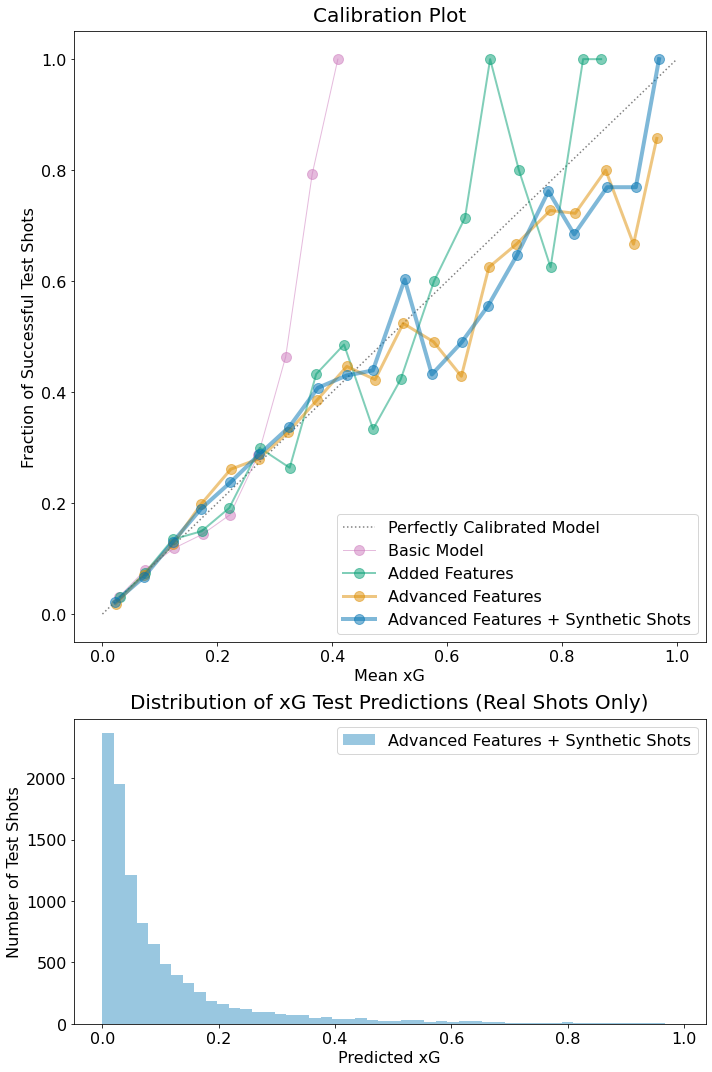

In [824]:
xG.plot_calibration_curve(df_shots_test, numBins=20, alpha=0.5, saveOutput=1, plotName='xG calibration incl synthetic shots')

---

### **Applying Logistic Regression Classifier and Calculating Model Fit Metrics**

In [825]:
xG.calculate_model_metrics(df_shots_test, 'xG_adv')

Brier Score: 0.07377658502787657

Precision Score: 0.696969696969697

Recall Score: 0.09072978303747535

F1 Score: 0.1605584642233857

AUC Score: 0.5431595767100488

AccuracyScore: 0.9045918873351185


In [826]:
xG.calculate_model_metrics(df_shots_test, 'xG_syn')

Brier Score: 0.07378580043136004

Precision Score: 0.6829268292682927

Recall Score: 0.08284023668639054

F1 Score: 0.1477572559366755

AUC Score: 0.5392699364047235

AccuracyScore: 0.9038976495090747


---

### **Applying xG Model (*Trained Using Advanced Features + Synthetic Shots*) to All Real Shots** 

In [827]:
df_shots['xG'] = xG_model_adv_syn.predict(df_shots_test)

### **For penalties, just apply the mean penalty conversion ratio**

In [828]:
df_pens['xG'] = df_pens.goalScoredFlag.mean()

# and now combining shots and penalties
df_shots_pens = pd.concat([df_shots, df_pens], ignore_index=True)

### **Important Modelling Points**

We have created sufficiently well-calibrated logistic models both with and without the synthetic shots.

The number of bins is a subjective decision, but changing the number of bins does not change the interpretation of the calibration of the model.

Model is very well-calibrated towards the lower end of the continuum, where the vast majority of the shots are taken from. Despite having over 40k shote, the number of shots with xG of over 0.5 are still very sparse.

Should also note that the model **globally calibrated** except for penalties. Meaning we have not fit different xG models for headers / strong or weak foot, and so we've not **explored conditional calibration**, and have treated penalties fairly simplistically.

**Where domain expertise comes in:**
* In the data: using the synthetic data that encapsultes knowledge of where shots aren't taken from because they wouldn't result in a goal (and hense why there aren't any shots in the real data to show for it). Helps to prevent overfitting when real goals go in in bizarre situations.
* In the model: handcrafted advanced features that add off-the-ball context to the on-the-ball data via proxies.

There's also a second benefit to the synthetic data: we can push the non-linear distance terms into the model, which is why we see the interaction term of `Dsquared` and `aShooting` but it doesn't appear in the advanced  model without the synthetic data.

### **Creating a Simple Dataframe `df_xG` Just Containing `eventId` & `xG` Columns**

In [829]:
df_xG = df_shots_pens[['eventId','xG']].reset_index(drop=True).copy()

### **And Now Joining `df_xG` Back OnTo Original `df`.**

> **All non-shots will get an xG of 0**

> `excess_xG` defined as `goalScoredFlag` - `xG`

In [830]:
df_xG = df.merge(df_xG, on=['eventId'], how='left').copy()

# filling NaN's with 0's
df_xG.xG.fillna(value=0, inplace=True)

In [831]:
df_xG['excess_xG'] = df_xG.goalScoredFlag - df_xG.xG

### **Outputting data to CSV**

In [832]:
df.columns

Index(['competition', 'season', 'seasonIndex', 'gameMonthIndex', 'matchId',
       'playerId', 'playerName', 'position', 'detailedPosition',
       'playerTeamId', 'minsPlayed', 'subIn', 'subOut',
       'replacedReplacingPlayerId', 'booking', 'eventId', 'eventType',
       'eventSubType', 'eventTypeId', 'x1', 'y1', 'x2', 'y2', 'gameTime',
       'timeStamp', 'periodId', 'homeTeamName', 'homeTeamId', 'awayTeamName',
       'awayTeamId', 'kickOffDateTime', 'minute', 'second', 'x1_m', 'y1_m',
       'x2_m', 'y2_m', 'possessionTeamId', 'possessionSequenceIndex',
       'possessionStartTime', 'possessionTimeSec', 'playerPossessionTimeSec',
       'goalDelta', 'numReds', 'goalScoredFlag', 'xT'],
      dtype='object')

In [833]:
df_xG.columns

Index(['competition', 'season', 'seasonIndex', 'gameMonthIndex', 'matchId',
       'playerId', 'playerName', 'position', 'detailedPosition',
       'playerTeamId', 'minsPlayed', 'subIn', 'subOut',
       'replacedReplacingPlayerId', 'booking', 'eventId', 'eventType',
       'eventSubType', 'eventTypeId', 'x1', 'y1', 'x2', 'y2', 'gameTime',
       'timeStamp', 'periodId', 'homeTeamName', 'homeTeamId', 'awayTeamName',
       'awayTeamId', 'kickOffDateTime', 'minute', 'second', 'x1_m', 'y1_m',
       'x2_m', 'y2_m', 'possessionTeamId', 'possessionSequenceIndex',
       'possessionStartTime', 'possessionTimeSec', 'playerPossessionTimeSec',
       'goalDelta', 'numReds', 'goalScoredFlag', 'xT', 'xG', 'excess_xG'],
      dtype='object')

In [834]:
# uploading the final xT & xG file
df_xG.to_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT & xG/Bayesian_Opta_xT_xG.csv')

---

### **Quick look at the data - Will explore more when producing player-specific plots**

In [835]:
df_xG_agg = df_xG.groupby(['season','playerTeamId','playerName']).agg({'excess_xG':np.sum}).reset_index().sort_values('excess_xG', ascending=False)

df_xG_agg['excess_xG_rank'] = df_xG_agg.sort_values(['season','excess_xG'], ascending=[True,False]).groupby('season').cumcount()+1

df_xG_agg.loc[df_xG_agg['excess_xG_rank'] <= 25].sort_values(['season','excess_xG_rank'], ascending=[True,True])

,season,playerTeamId,playerName,excess_xG,excess_xG_rank
212,2017/18,14,Mohamed Salah,25.521387,1
94,2017/18,6,Harry Kane,17.133622,2
217,2017/18,14,Sadio Mané,14.184069,3
384,2017/18,43,Raheem Sterling,14.127624,4
183,2017/18,13,Jamie Vardy,12.290623,5
216,2017/18,14,Roberto Firmino,11.399603,6
22,2017/18,1,Romelu Lukaku,11.195289,7
385,2017/18,43,Sergio Agüero,10.085387,8
374,2017/18,43,Gabriel Jesus,9.795329,9
712,2017/18,186,Cristiano Ronaldo,9.333836,10
